Install required packages

In [16]:
!pip install transformers
!pip install -q datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import packages

In [17]:
import json
from PIL import Image
import os 
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
from transformers import AutoProcessor
import numpy as np
from transformers import AutoModelForCausalLM
import torch
import getpass
from IPython.utils.io import temp_pyfile


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Set up the root folder path
root = getpass.getpass('Enter the value for root: ')

Enter the value for root: ··········


In [20]:
class ImageCaptioningDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

class ImageCaptioningModel:
    def __init__(self, processor, dataset):
        self.processor = processor
        self.dataset = dataset
        self.train_dataloader = None
        self.model = None
    
    def initialize_processor(self):
        self.processor = AutoProcessor.from_pretrained("microsoft/git-base")
    
    def create_dataset(self):
        self.dataset = ImageCaptioningDataset(self.dataset, self.processor)
    
    def create_dataloader(self, batch_size=2, shuffle=True):
        self.train_dataloader = DataLoader(self.dataset, shuffle=shuffle, batch_size=batch_size)
    
    def initialize_model(self):
        self.model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")
    
    def train(self, optimizer, num_epochs=30, device="cuda"):
        self.model.to(device)
        self.model.train()
        for epoch in range(num_epochs):
            print("Epoch:", epoch)
            for idx, batch in enumerate(self.train_dataloader):
                input_ids = batch.pop("input_ids").to(device)
                pixel_values = batch.pop("pixel_values").to(device)

                outputs = self.model(
                    input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids
                )

                loss = outputs.loss

                loss.backward()

                optimizer.step()
                optimizer.zero_grad()
            print("Loss:", loss.item())

    
    def generate_caption(self, image_path, device="cuda", max_length=50):
        with open(image_path, 'rb') as f:
            image = Image.open(f)
            image_test = image.copy()
        
        inputs = self.processor(images=image_test, return_tensors="pt").to(device)
        pixel_values = inputs.pixel_values

        generated_ids = self.model.generate(pixel_values=pixel_values, max_length=max_length)
        generated_caption = self.processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        return generated_caption

In [21]:
def load_image(filepath):
    copyed_image = None
    with open(filepath, 'rb') as f:
        image = Image.open(f)
        copyed_image = image.copy()
    return copyed_image

In [22]:
# Prepare the data
captions = [
    {"file_name": "curry1.jpg", "text": "this is curry"},
    {"file_name": "curry2.jpg", "text": "this is curry"},
    {"file_name": "curry3.jpg", "text": "this is curry"},
    {"file_name": "kobe1.jpg", "text": "this is kobe"},
    {"file_name": "kobe2.jpg", "text": "this is kobe"},
    {"file_name": "kobe3.jpeg", "text": "this is kobe"}
]


for caption in captions:
    temp_image = load_image(root+"/"+caption['file_name'])
    caption["image"] = temp_image


# Create the dataset
dataset = Dataset.from_dict({'image': [c['image'] for c in captions], 'text': [c['text'] for c in captions]})

# Initialize the processor
processor = AutoProcessor.from_pretrained("microsoft/git-base")

# Create the training dataset
train_dataset = ImageCaptioningDataset(dataset, processor)

# Create the model
image_captioning_model = ImageCaptioningModel(processor, train_dataset)

# Initialize the model
image_captioning_model.initialize_model()

# Create the data loader
image_captioning_model.create_dataloader()

# Initialize the optimizer
optimizer = torch.optim.AdamW(image_captioning_model.model.parameters(), lr=5e-5)



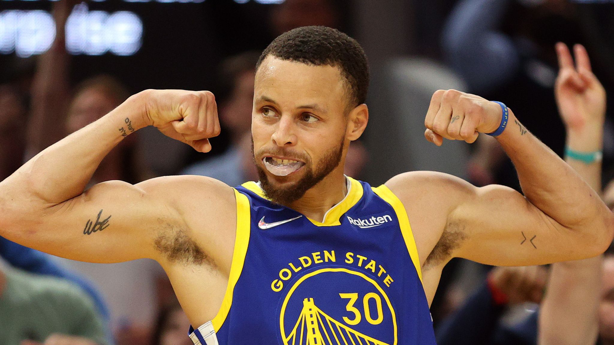

In [23]:
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [24]:
example["text"]


'this is curry'

In [25]:

# Train the model
image_captioning_model.train(optimizer, num_epochs=50, device="cuda")

Epoch: 0
Loss: 10.296736717224121
Epoch: 1
Loss: 9.484938621520996
Epoch: 2
Loss: 8.91776180267334
Epoch: 3
Loss: 8.507833480834961
Epoch: 4
Loss: 8.169539451599121
Epoch: 5
Loss: 7.857710361480713
Epoch: 6
Loss: 7.556143760681152
Epoch: 7
Loss: 7.251429080963135
Epoch: 8
Loss: 6.94148588180542
Epoch: 9
Loss: 6.629276275634766
Epoch: 10
Loss: 6.305672645568848
Epoch: 11
Loss: 5.991729736328125
Epoch: 12
Loss: 5.665164470672607
Epoch: 13
Loss: 5.3281707763671875
Epoch: 14
Loss: 5.001104354858398
Epoch: 15
Loss: 4.65212345123291
Epoch: 16
Loss: 4.318506717681885
Epoch: 17
Loss: 3.972008466720581
Epoch: 18
Loss: 3.635852098464966
Epoch: 19
Loss: 3.295243740081787
Epoch: 20
Loss: 2.960662603378296
Epoch: 21
Loss: 2.629915237426758
Epoch: 22
Loss: 2.309633493423462
Epoch: 23
Loss: 2.003081798553467
Epoch: 24
Loss: 1.7124807834625244
Epoch: 25
Loss: 1.4468504190444946
Epoch: 26
Loss: 1.2072690725326538
Epoch: 27
Loss: 0.9956362843513489
Epoch: 28
Loss: 0.8180015683174133
Epoch: 29
Loss: 0.67

In [26]:

# Test the model
image_path = os.path.join(root, "test/kobe_test.jpg")
generated_caption = image_captioning_model.generate_caption(image_path, device="cuda", max_length=50)

In [27]:
with open(image_path, 'rb') as f:
    image = Image.open(f)
    image_test = image.copy()

In [28]:
print("Generated Caption:", generated_caption)

Generated Caption: this is kobe


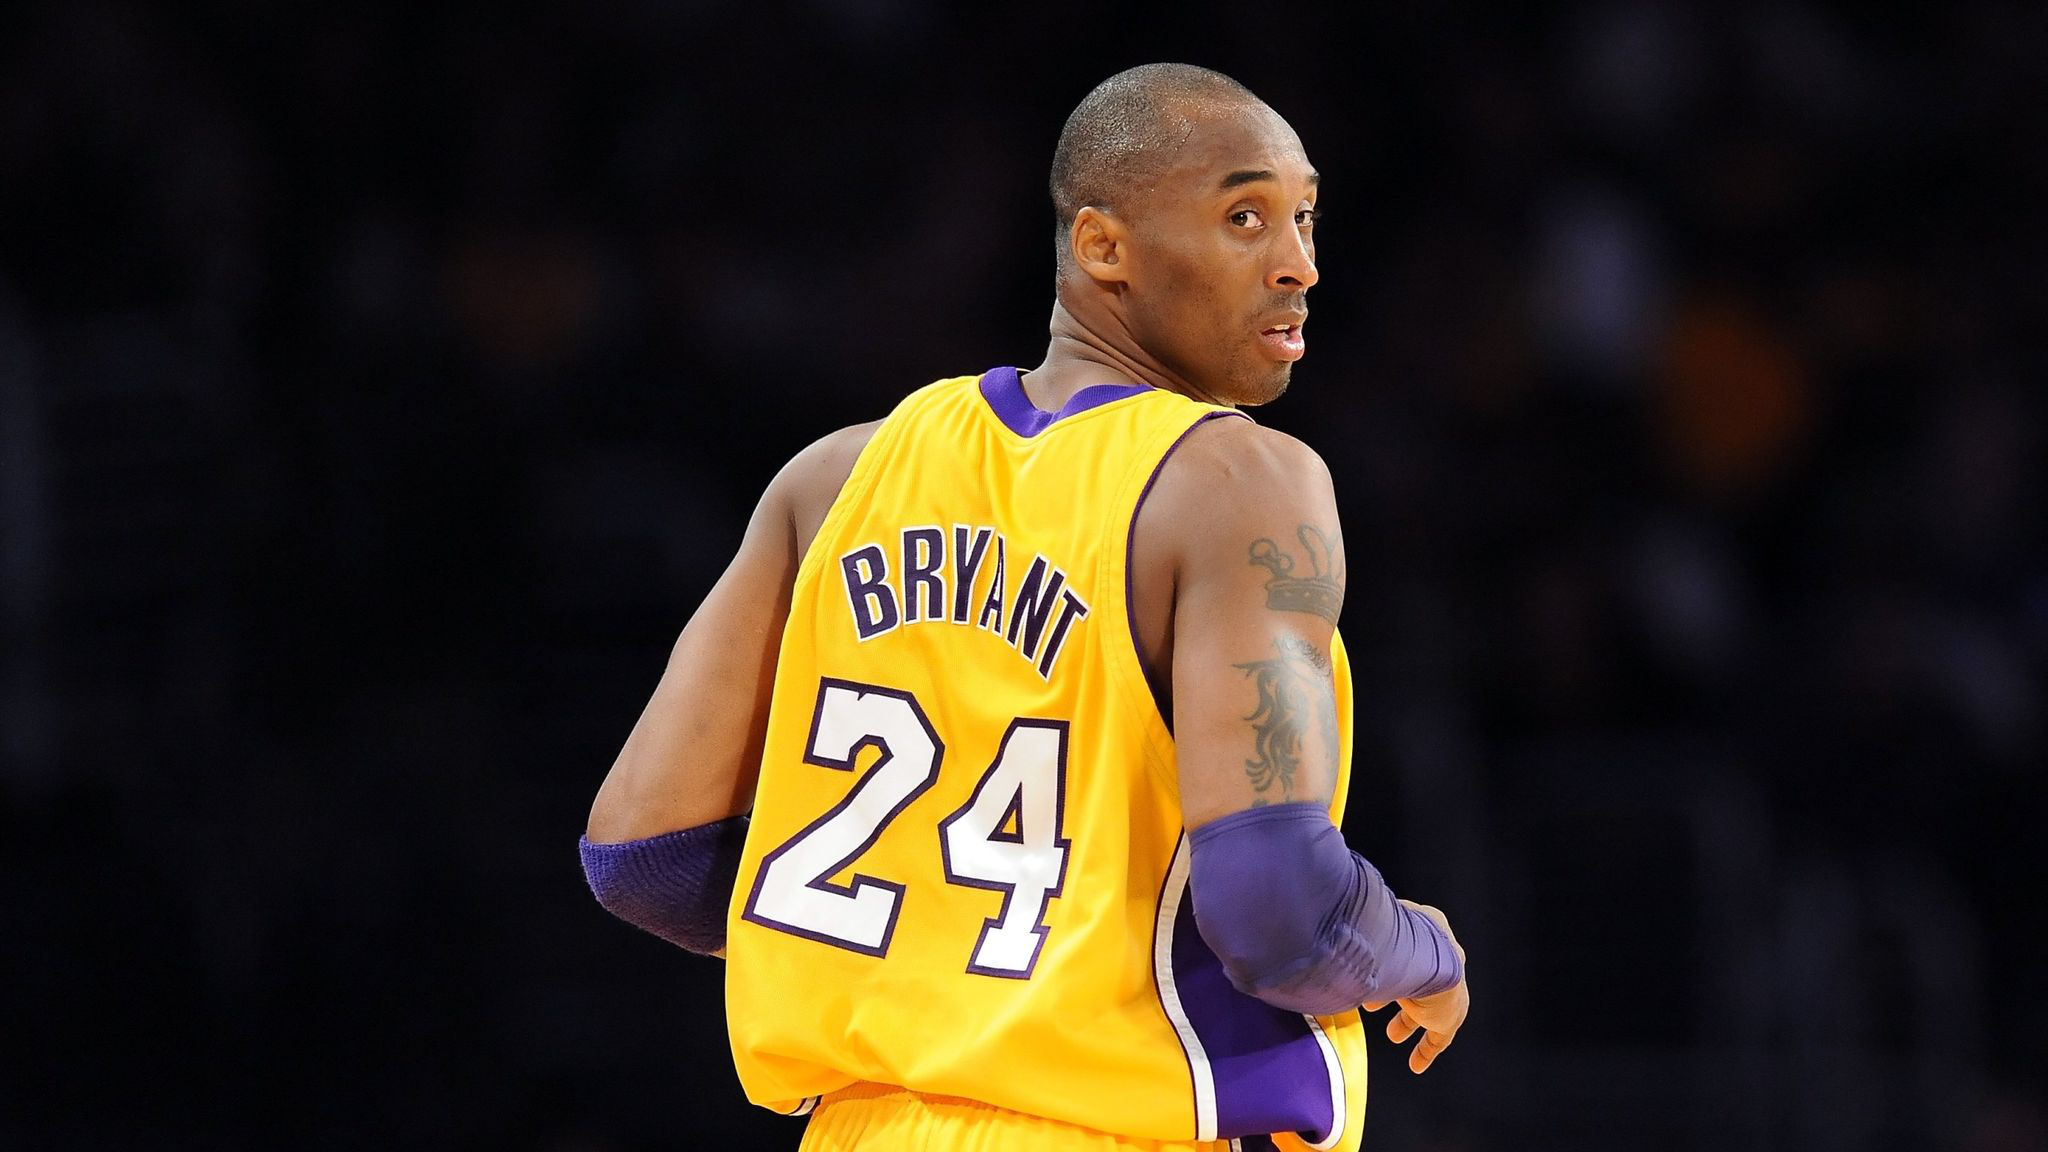

In [29]:
image